# Mutual Information (MI)

Saleh Rezaeiravesh, saleh.rezaeiravesh@manchester.ac.uk
___

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import sys
sys.path.append('../core/')
from mi import mi, mi_multiLag
import synData

## Mutual Information (MI)

[Shannon 1948](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf): MI can be used to quantify the overlap of information content of two systems/variables.  

### MI for Random Variables (RVs)
Consider two continuous **random variables** $X$ and $Y$, for which we have $n$ jointly observed $(x_i,y_i)$. If the joint PDF of $X$ and $Y$ is $f(x,y)$, then the mutual information between $X$ and $Y$ is, 

$$
I(X,Y) =\int\int p(x,y)\ln( \frac{p(x,y)}{p_x(x)p_y(y)}) dx dy
$$

### MI for Time Series (TS)
* In contrast for uncorrelated RVs $X, Y$, where the mutual information is a symmetric quantity, for $x(t)$ and $y(t)$, the MI can be **asymmetric**. 

* MI measure **nonlinear** dependency between time series or RVs.

* According to [Schreiber, 2000](https://arxiv.org/pdf/nlin/0001042), the MI at lag $\tau$ for two time series $x_t$ and $y_t$ is defined as, 

$$
M_{xy}(\tau) = - \sum_{k} p(x_k,y_{k-\tau}) \log\frac{p(x_k,y_{k-\tau})}{p(x_k)p(y_k)}
$$


**Note:** Mutual information (MI) is an asymmetric metric. 

## Methods for Estimating MI

### KDE/Binning methods
Our aim is to esimtate $\hat{I}(X,Y)$ from a set of finite observed samples $z_i=(x_i,y_i)$, $i=1,2,\cdots,n$.

In many text books, e.g. [this one](http://staff.ustc.edu.cn/~cgong821/Wiley.Interscience.Elements.of.Information.Theory.Jul.2006.eBook-DDU.pdf), the **mutual information (MI)** is written as, 

$$
I(X,Y) = H(X) + H(Y) - H(X,Y)
$$


where, 
* $H(X)$ and $H(Y)$ are the **marginal entropies**, and
* $H(X,Y)$ is the **joint entropy**

The above three entropy can be estimated using KDE or Binning methods, for both RVs and TS. 

For time series, the above expression reads as, 

$$
I(x_k,y_{k-\tau}) = H(x_k) + H(y_k) - H(x_k,y_{k-\tau})
$$

We can extend the KDE/Binning methods to compute $I(X,Y)$ by:
1. Estimate the marginal PDFs of $X$ and $Y$
2. Estimate the joint PDF of $X$ and $Y$
3. Numerically compute the above double integral

### KSG (KL/KNN-based) method:


As detailed in [Kraskov-Stogbauer-Grassberger (KSG), 2004](https://arxiv.org/pdf/cond-mat/0305641), the error involved in estimation of each separate $H$ using KL/KNN method are not cencelled by each others' and would propagate into the estimated $I(X,y)$:

$$
\hat{H}(X) = -\psi(k)+\psi(N)+\ln c_{d_x} +\frac{d_x}{n}\sum_{i=1}^n \ln \epsilon_i
$$

$$
\hat{H}(Y) = -\psi(k)+\psi(N)+\ln c_{d_y} +\frac{d_y}{n}\sum_{i=1}^n \ln \epsilon_i
$$

$$
\hat{H}(X,Y) = -\psi(k)+\psi(N)+\ln (c_{d_x}c_{d_y}) +\frac{d_x+d_y}{n}\sum_{i=1}^n \ln \epsilon_i
$$

This reference proposed alternative approach based on the KL/KNN estimator. We call this **KSG Estimator**. They proposed two estimators, where we use the 1st one. 

$$
I^{(1)}(X,Y) = \psi(k) + \psi(n) - \langle \psi(n_x)+\psi(n_y)\rangle
$$

$$
I^{(2)}(X,Y) = \psi(k) + \psi(n) - 1/k - \langle \psi(n_x+1)+\psi(n_y+1)\rangle
$$

The above expressions can be evaluated by the KNN method, for both RVs and time series. 

## Validation of MI estimators for RVs

For multivariate Guassian variables $(X_1,X_2,\cdots,X_m)$ with mean zero and unit standard deviation and covariance matrix $V_{m\times m}$, the exact MI is, 

$$
I(X_1,X_2,\cdots,X_m) = -\frac{1}{2}\ln(\det(V))
$$

This implies that if the correlation between each pair of joint Gaussian RVs goes to zero, the associated MI goes to zero, too. 

In [2]:
#create joint samples from bivariate Gaussian distribution
rho = -0.8   #correlation coefficient - can try different values from [-1,1]
mean=np.zeros(2)
cov=np.array([[1,rho],[rho,1]])   
np.random.seed(205)
x_ = np.random.multivariate_normal(mean, cov,10000)

#Exact and KDE values of MI 
mi_exact = -0.5*np.log(la.det(cov))

#MI estimated by the KDE method with Monte Carlo integration 
mi_kde = mi(x_[:,0],x_[:,1]).kde()

#MI estimated by the KSG method
mi_ksg = mi(x_[:,0],x_[:,1]).ksg(k=3)

print('Exact MI: ',mi_exact)
print('KDE MI: ',mi_kde)
print('KSG MI: ',mi_ksg)

Exact MI:  0.5108256237659909
KDE MI:  0.5165657559270311
KSG MI:  0.5027533730023723


## Validation of MI estimators for time series

Below, we can compute MI between a bivariate time series generated from a VAR(p) with $p\leq 1$.

In [3]:
xt, _, _ = synData.varSampGen(n=10000,order=3)

In [4]:
lag = 1

#KDE method
mi_kde = mi(xt[:-lag,0], xt[lag:,1]).kde()
print('MI - kde method:',mi_kde)

#KSG method
mi_ksg = mi(xt[:-lag,0], xt[lag:,1]).ksg(k=3)
print('MI - ksg method:',mi_ksg)

MI - kde method: 0.45651886474788395
MI - ksg method: 0.45596549825345534


We can compute the MI between the two time series at various lags: $I(x_k,y_{k-\tau})$

In [5]:
lagList_=np.arange(0,10,1)

mi_kde_list, maxMI_kde, maxMIlag_kde = mi_multiLag(xt[:,0],xt[:,1],lagList_).kde()
mi_ksg_list, maxMI_ksg, maxMIlag_ksg = mi_multiLag(xt[:,0],xt[:,1],lagList_).ksg(k=3)

print('Max MI and its lag - KDE method:',maxMI_kde, maxMIlag_kde)
print('Max MI and its lag - KSG method:',maxMI_ksg, maxMIlag_ksg)

Max MI and its lag - KDE method: 0.8608208557526051 0
Max MI and its lag - KSG method: 0.8481351438928577 0


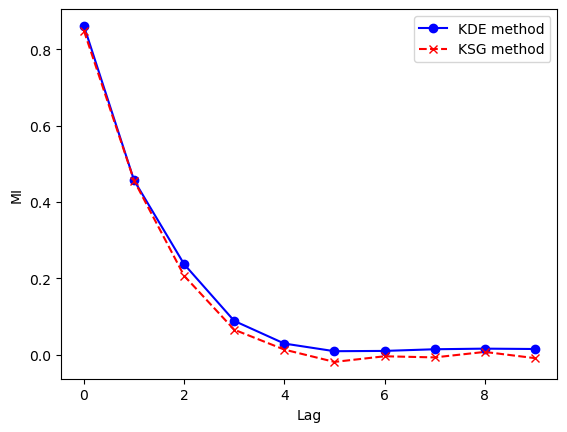

In [6]:
plt.plot(lagList_,mi_kde_list,'-ob',label='KDE method')
plt.plot(lagList_,mi_ksg_list,'--xr',label='KSG method')

plt.xlabel('Lag')
plt.ylabel('MI')
plt.legend(loc='best')
plt.show()

We can repeat above but changing the lagged samples to the other time series to show the asymmetry of the MI. We compute $I(x_{k-\tau},y_{k})$ 

In [7]:
lagList_=np.arange(0,10,1)

mi_kde_list, maxMI_kde, maxMIlag_kde = mi_multiLag(xt[:,1],xt[:,0],lagList_).kde()
mi_ksg_list, maxMI_ksg, maxMIlag_ksg = mi_multiLag(xt[:,1],xt[:,0],lagList_).ksg(k=3)

print('Max MI and its lag - KDE method:',maxMI_kde, maxMIlag_kde)
print('Max MI and its lag - KSG method:',maxMI_ksg, maxMIlag_ksg)

Max MI and its lag - KDE method: 0.8608208557526051 0
Max MI and its lag - KSG method: 0.8481351438928577 0


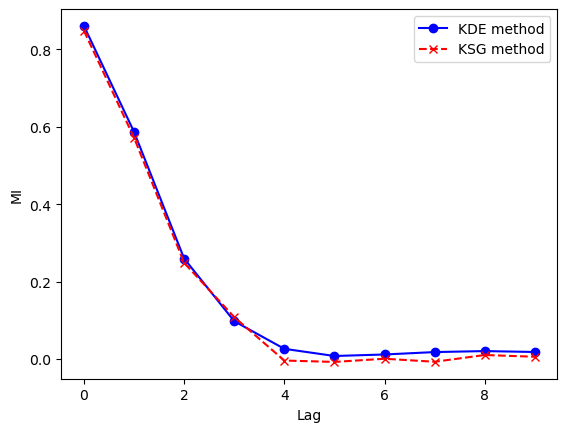

In [8]:
plt.plot(lagList_,mi_kde_list,'-ob',label='KDE method')
plt.plot(lagList_,mi_ksg_list,'--xr',label='KSG method')

plt.xlabel('Lag')
plt.ylabel('MI')
plt.legend(loc='best')
plt.show()